In [1]:
import sys
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split

# visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# seaborn styling default
sns.set_theme(style='darkgrid')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('derived_data/combined_dataset.csv', index_col = [0])

## Visiualise the Data

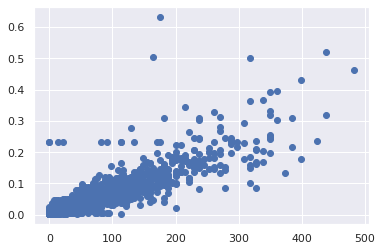

In [3]:
plt.scatter(df['Actiwatch activity counts'], df['Apple Watch ENMO'])

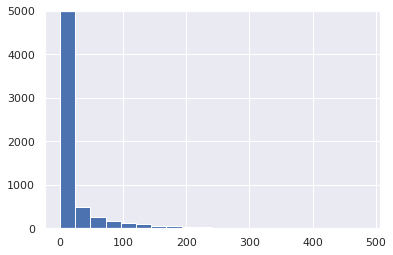

In [4]:

n_bins = 20

# Generate two normal distributions
dist1 = df['Actiwatch activity counts']
plt.ylim(0,5000)
plt.hist(dist1, bins = n_bins)
plt.show()

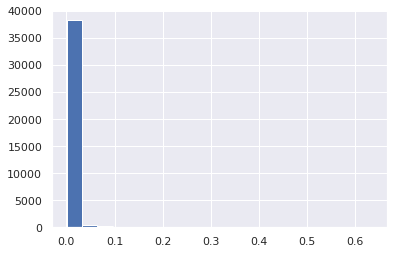

In [5]:
n_bins = 20

# Generate two normal distributions
dist1 = df['Apple Watch ENMO']
plt.hist(dist1, bins = n_bins)
plt.show()

### Sample stratify Data for model building


In [6]:
df_x = df[['Apple Watch ENMO', 'ELMO_before','ELMO_after']].copy()
df_y  = df[['Actiwatch activity counts']].copy()
nums_x = df_x.to_numpy()
nums_y = df_y.to_numpy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(nums_x, nums_y, test_size=0.33, random_state=42)
X_train = X_train.astype('float64')
y_train = y_train.astype('int')
X_test = X_test.astype('float64')
y_test = y_test.astype('int')

### Define functions for testing

Applies the  Philips’ Actiware software algorithm to a dataframe and returns a new dataframe with a column predicted_actiwatch whihc contains the totals counts for the given row

In [8]:
def phillips_alogrithn(df):
    for index, row in df.iterrows():
        if index <= 8 or index >= len(df.index)-8:
            continue

        #part 1
        p1 = 0
        for i in range(-8,-4):
            j = index + i
            p1 = p1 + df.loc[j]['predicted_actiwatch']

        #part 2
        p2 = 0
        for i in range(-4,0):
            j = index + i
            p2 = p2 + df.loc[j]['predicted_actiwatch']

        #part 3
        p3 = 0
        for i in range(1,5):
            j = index + i
            p3 = p3 + df.loc[j]['predicted_actiwatch']

        #part 4
        p4 = 0
        for i in range(5,9):
            j = index + i
            p4 = p4 + df.loc[j]['predicted_actiwatch']

        #Calculate total counts
        df.at[index, 'total_counts'] = 0.04*p1 + 0.2*p2 + 4*df.loc[index]['predicted_actiwatch'] + 0.2*p3 + 0.04*p4

    return df



Simple function given a threshold and total count returns 1 for awake and zero for sleep

In [9]:
def predict_sleep_awake(row, threshold):
    if row['total_counts'] <= threshold:
        return 0
    else:
        return 1


    

Given a patient file, sklearn model and threshold returns a dataframe with sleep/wake prediction for patient

In [10]:
def test_model_on_patient(patientFile, model, threshold):
    #import patient file
    import_df = pd.read_csv('derived_data/'+ patientFile +'.csv')

    #Grab fields required for prediction
    test_df = import_df[['Apple Watch ENMO','ELMO_before','ELMO_after']].copy()
    test_nums = test_df.to_numpy()

    #predict actiwatch counts
    predict = model.predict(test_nums).astype('int')
    import_df['predicted_actiwatch']= predict

    #determine total counts
    predicted_df = phillips_alogrithn(import_df)

    #determine sleep or awake
    predicted_df['predicted_sleep'] = predicted_df.apply (lambda row: predict_sleep_awake(row, threshold), axis=1)

    return import_df

   


Uses confunsion matrix tp determine accuracy

In [39]:
def check_accuracy(df):
    #sleep is zero, awake is one
    df_accuracy = df.dropna(subset=['Actiware classification']).copy()

    TP=0
    TN=0
    FP=0
    FN=0

    for index, row in df_accuracy.iterrows():
        if row['Actiware classification'] == 1 and row['predicted_sleep'] == 1:
            TN+=1
        if row['Actiware classification'] == 1 and row['predicted_sleep'] == 0:
            FP+=1
        if row['Actiware classification'] == 0 and row['predicted_sleep'] == 0:
            TP+=1
        if row['Actiware classification'] == 0 and row['predicted_sleep'] == 1:
            FN+=1
    
    accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    sensitivity = (TP/(TP+FN))*100 #Recall
    precision  = (TP/(TP+FP))*100 
    fnr = (FN/(TP+FN))*100 #False Negative Rate
    specificity  = (TN/(TN+FP))*100 
    fpr = 100 - specificity #False Positive Rate
    return accuracy, sensitivity, fnr, specificity, fpr, precision

Check accuracy on multiple datasets

In [40]:
from numpy import average


def check_overall_accuracy(model, threshold):
    accuracies = []
    sensitivitys = []
    fnrs = []
    specificitys = []
    fprs = []
    precisions = []
    fileNames = ['P02_N1', 'P02_N2', 'P03_N1', 'P03_N2','P04_N1','P04_N2','P05_N1', 'P05_N2','P06_N1','P06_N2','P07_N1','P07_N2','P11_N1','P11_N2','P12_N1','P12_N2','P14_N1',
    'P14_N2','P15_N2','P16_N1','P16_N2','P17_N1']
    for fileName in fileNames:
        file = fileName + '_filtered'
        df1 = test_model_on_patient(file, model, threshold)
        accuracy, sensitivity, fnr, specificity, fpr, precision = check_accuracy(df1)
        accuracies.append(accuracy)
        sensitivitys.append(sensitivity)
        fnrs.append(fnr)
        specificitys.append(specificity)
        fprs.append(fpr)
        precisions.append(precision)
    
    recall = average(sensitivitys)
    Precision = average(precisions)
    f1 = (2*Precision*recall)/(recall+Precision)

    output = "Accuracy: " + str(average(accuracies)) +"\nSensitivity: "+ str(recall)+"\nFalse Negative Rate: "+ str(average(fnrs))+"\nSpecificity: "+ str(average(specificitys))+"\nFalse Positive Rate: "+ str(average(fprs)) + " \n F measure: "+ str(f1)
    return output




### Test Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
model = LinearRegression().fit(X_train, y_train)

In [15]:
r_sq = model.score(X_test, y_test)
print(f"coefficient of determination: {r_sq}")


coefficient of determination: 0.8032916992589149


In [16]:
test_df = test_model_on_patient('P03_N1_filtered', model,40)
check_accuracy(test_df)

(99.08079342041606,
 99.84431759211209,
 0.15568240788790866,
 88.57142857142857,
 11.42857142857143)

In [17]:
check_overall_accuracy(model, 40)

'Accuracy: 97.04945921548206\nSensitivity: 98.20721515061132\nFalse Negative Rate: 1.7927848493886671\nSpecificity: 82.60247103471168\nFalse Positive Rate: 17.3975289652883'

### Test on Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [20]:
regressor.fit(X_train, y_train) 

RandomForestRegressor(random_state=0)

In [21]:
r_sq_2 = regressor.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_2}")

coefficient of determination: 0.8858684317421877


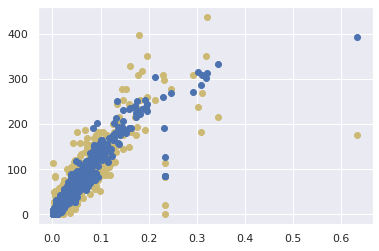

In [22]:
plt.plot(X_test[:, 0],y_test, 'yo', X_test[:, 0],regressor.predict(X_test), 'bo')

Test on patient

In [23]:
test_df = test_model_on_patient('P03_N1_filtered', regressor,40)
check_accuracy(test_df)

(98.98403483309144,
 99.53295277633627,
 0.46704722366372603,
 91.42857142857143,
 8.57142857142857)

In [41]:
check_overall_accuracy(regressor, 40)

'Accuracy: 98.69458130483113\nSensitivity: 99.35213181018652\nFalse Negative Rate: 0.6478681898134796\nSpecificity: 90.80181375195706\nFalse Positive Rate: 9.198186248042935 \n F measure: 99.28569797536377'

Create AUC Curve

for regression look into 
Mean Squared Error (MSE).
Root Mean Squared Error (RMSE).
Mean Absolute Error (MAE)

In [25]:
from sklearn import metrics

In [26]:
y_predicted_test = regressor.predict(X_test)

In [27]:
auc_df_RF= test_df.dropna(subset=['Actiware classification']).copy()
true_result = auc_df_RF['Actiware classification'].to_numpy()
true_result = true_result.astype(int)
predicted_result = auc_df_RF['predicted_sleep'].to_numpy()

In [28]:
fpr, tpr, _ = metrics.roc_curve(true_result,  predicted_result)

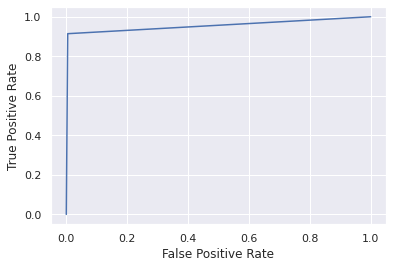

In [29]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Test on Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

In [31]:
gnb = GaussianNB()

In [32]:
gnb.fit(X_train, y_train)


GaussianNB()

In [33]:
r_sq_3 = gnb.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_3}")

coefficient of determination: 0.916885930970438


Test on patient

In [34]:
test_df = test_model_on_patient('P03_N1_filtered', gnb,40)
check_accuracy(test_df)

(98.59700048379294,
 99.63674104826154,
 0.3632589517384536,
 84.28571428571429,
 15.714285714285708)

### Test on SVM

In [35]:
from sklearn import svm

In [36]:
regr = svm.SVR()
regr.fit(X_train, y_train)

SVR()

In [37]:
r_sq_4 = regr.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_4}")

coefficient of determination: 0.5723910559626157


Test on patient

In [38]:
test_df = test_model_on_patient('P03_N1_filtered', regr,40)
check_accuracy(test_df)

(98.30672472181907,
 99.89621172807472,
 0.10378827192527244,
 76.42857142857142,
 23.571428571428584)